# Summary


## The goal

The primary goal is to build a model to predict a client's propensity to default on loan.


## The data

The original 3342-row dataset has 18 columns, including:
- 1 unnamed,
- 1 for class labels `tag_in_six_months`,  
- 1 for prediction by a CompanyX model  `future_bad_probability`, 
- 15 remaining with info about clients can be possibly used for model building.  


## Plan
- Check the data quality for data type, missing data, outlier.
- Data preprocessing and visualization/statistics.
- Model building.
- Model evaluation and comparison with the CompanyX model.


## Key findings

For detailed discussion on my choices at every step, see the detailed analysis session. Below is a brief summary.

* Data quality.

    - There are duplicates in `client_id` meaning for returning clients. 78 clients have a second record at a different date. Only newest records are kept. 

    - `credit_score` and `external score` contain strange values: being negative and/or extremely large. The (400) clients with these strange `external score` values mostly don't have records for `credit_score`.

    - More than 40% values missing in `max_successful_repayments`.
    
    - Missing values for `sum_failed_repayments ` and `max_failed_repayments` happen for the same set of clients.


* Various techniques have been used to clean/impute the dataset. Finally, a clean dataset with 2855 rows and 10 input features (plus 1 target variable) is used for modeling. 


* Model building. For a quick implementation, I use a simple 5-max-depth random forest model to train on 80% of the dataset and then evaluate and compare on the remain 20% data the trained model to the result from the current CompanyX model provided.


* Model evaluation. The metrics for evaluation include the precision-recall curve and its associated area-under-the-curve score as the dataset is unbalanced and my priority is to focus on predicting the positive class. The ROC and area-under-the-ROC curve AUC are also provided for comparison. 

    - For the precision-recall curve, the random forest model has been able to reach an AUC score of 0.82 compared to 0.89 by the CompanyX model.

    - For ROC curve, the random forest model gives an AUC of 0.92 compared to 0.97 by the CompanyX model.


- Key predictive indicators from correlation analysis and from the random forest model includes: `sum_failed_repayments`, `available_credit`, `recent_successful_repayments`, `credit_inquiries_count`, `client_industry_unknown`.



## Future work
- Fine tuning model selection by doing hyperparameter search with a cross validation scheme. Try more advanced models to see if the performance is improved.


- Error analysis: find common patterns among clients that are misclassified by the model to have more information how to improve the model performance.


- Feature engineering.



In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

np.random.seed(2018)  # for reproducibility

# Detailed analysis

## Data loading and overview

In [2]:
!ls ./data

lending_bad_client_dataset.csv


In [3]:
# load data from csv file
data_orig = pd.read_csv('./data/lending_bad_client_dataset.csv', header=0)
print('Shape of the original dataset ', data_orig.shape)
data_orig.head()

Shape of the original dataset  (3342, 18)


,Unnamed: 0,client_id,pit,recent_successful_repayments,future_bad_probability,available_credit,balance,sum_failed_repayments,max_failed_repayments,credit_score,external score,credit_inquiries_count,credit_open_balance,years_on_file,max_successful_repayments,missing_report,client_industry_unknown,tag_in_six_months
0,1,10857,7/8/17,7267.064596,0.948553,2224.550794,7675.651539,335.790581,330.416817,685.0,993.5,7.0,29835.0,between 0.5 and 1 years,0.0,0,0,bad
1,5,14108,27/08/2017,-24.261807,0.913876,-176.241705,6159.636587,1036.432068,261.618821,768.0,1118.0,16.0,393824.0,between 5 and 6 years,0.0,0,1,bad
2,8,12019,25/07/2017,23799.444140,0.895160,30614.475400,17586.950490,1679.119093,628.316313,713.0,1035.5,8.0,419783.0,between 3 and 5 years,2.0,0,0,bad
3,10,2647,26/03/2017,17052.245390,0.866898,443.083235,18855.047720,0.000000,0.000000,662.0,959.0,3.0,212813.0,between 1.5 and 2 years,NaN,0,0,bad
4,11,15281,8/5/17,-9.609538,0.861520,-4537.729415,19660.129670,2365.986493,873.598775,660.0,956.0,13.0,50356.0,between 2 and 2.5 years,NaN,0,0,bad


In [4]:
# number of rows with non-null values for each columns, data types
data_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3342 entries, 0 to 3341
Data columns (total 18 columns):
Unnamed: 0                      3342 non-null int64
client_id                       3342 non-null int64
pit                             3342 non-null object
recent_successful_repayments    3340 non-null float64
future_bad_probability          3342 non-null float64
available_credit                3302 non-null float64
balance                         3312 non-null float64
sum_failed_repayments           3313 non-null float64
max_failed_repayments           3313 non-null float64
credit_score                    2932 non-null float64
external score                  3342 non-null float64
credit_inquiries_count          2921 non-null float64
credit_open_balance             2905 non-null float64
years_on_file                   2733 non-null object
max_successful_repayments       1967 non-null float64
missing_report                  3342 non-null int64
client_industry_unknown         3342 

## Data visualization and cleaning/preprocessing

### Data types 

There are 3 categorical features, `missing_report`, `client_industry_unknown`, and `years_on_file`, among which the first two are in a numerical form already. 

For a numerical representation of `years_on_file` feature, I map its 18 values to indexes from 0 to 17. 


In [5]:
# copy to new dataframe to be modified later
data = data_orig[data_orig.columns[1:]].copy(deep = True)

In [6]:
# datetime data type
data['pit'] = pd.to_datetime(data['pit'])

In [7]:
# Mapping `years_on_file` values into indexes based on year period: getting years
nb_year_list = []
for item in data['years_on_file'].value_counts().index:
    word_list = item.split()
    if len(word_list) == 5:
        nb_year_list.append(word_list[1])
        nb_year_list.append(word_list[3])
    else:
        nb_year_list.append(word_list[2])

nb_year_list = [float(i) for i in nb_year_list]
nb_year_list = list(set(nb_year_list))
nb_year_list.sort()
print(len(nb_year_list), nb_year_list)                                                           

17 [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 5.0, 6.0, 8.0, 10.0, 12.0, 14.0, 17.0, 20.0, 25.0, 30.0, 35.0]


In [8]:
# Mapping `years_on_file` values into indexes based on year period: 
# replacing 'year_on_file' value with index from 0 - 17
mapping_years_on_file = {}
mapping_years_on_file['less than 0.5 year'] = 0
for item in data['years_on_file'].value_counts().index:
    word_list = item.split()
    if len(word_list) == 5:
        mapping_years_on_file[item] = 1 + nb_year_list.index(float(word_list[1]))
mapping_years_on_file['more than 35 years'] = len(nb_year_list)

data['years_on_file'].replace(mapping_years_on_file, inplace = True)

In [9]:
mapping_years_on_file

{'between 0.5 and 1 years': 1,
 'between 1 and 1.5 years': 2,
 'between 1.5 and 2 years': 3,
 'between 10 and 12 years': 10,
 'between 12 and 14 years': 11,
 'between 14 and 17 years': 12,
 'between 17 and 20 years': 13,
 'between 2 and 2.5 years': 4,
 'between 2.5 and 3 years': 5,
 'between 20 and 25 years': 14,
 'between 25 and 30 years': 15,
 'between 3 and 5 years': 6,
 'between 30 and 35 years': 16,
 'between 5 and 6 years': 7,
 'between 6 and 8 years': 8,
 'between 8 and 10 years': 9,
 'less than 0.5 year': 0,
 'more than 35 years': 17}



### Duplicates

There is no duplicate in the dataset. 

However, there are duplicates in `client_id` - might be returning clients. Checking further, I see that 78 clients have a second record in the dataset at a different point in time `pit`. The two records for some clients are not entirely consistent. An example is client_id = 1767: the first record on 2017-04-02 says `year_on_file` is between 1.5 and 2 years, but the second record on 2017-04-29, just 27 days after the first, reports `year_on_file` is between 3 and 5 years, a year difference to the first. 

I would definitely discuss this issue with the engineering and/or other teams to see weather there were errors during data collecting pipeline or in some data sources.

For now, I decide to delete the duplicate version such that there's only one record with the newest record based on `pit` for each client_ids. This step helps to decorrelate the dataset for the modeling step later. 




In [10]:
# check for duplicates
data[data.duplicated(keep=False)].index

Int64Index([], dtype='int64')

In [11]:
# check for duplicates in client_id
print('Number of duplicates, including the originals, in client_ids',\
      data[data.duplicated(subset=['client_id'],keep=False)].shape[0])
print('Number of unique client_ids among duplicates',\
      len(data[data.duplicated(subset=['client_id'],keep=False)].client_id.unique()))

Number of duplicates, including the originals, in client_ids 156
Number of unique client_ids among duplicates 78


In [12]:
# check number of duplicate for each client_id
data[data.duplicated(subset=['client_id'],keep=False)].client_id.value_counts().tail()

6070     2
3000     2
20409    2
23921    2
1539     2
Name: client_id, dtype: int64

In [13]:
# check for one client as an example. Seems like a returning client. 
data[data.client_id== 1767]

,client_id,pit,recent_successful_repayments,future_bad_probability,available_credit,balance,sum_failed_repayments,max_failed_repayments,credit_score,external score,credit_inquiries_count,credit_open_balance,years_on_file,max_successful_repayments,missing_report,client_industry_unknown,tag_in_six_months
75,1767,2017-04-02,5259.783245,0.706293,5627.930188,4400.538736,2777.732543,373.809135,706.0,1025.0,12.0,8814.0,3.0,6.0,0,0,bad
3031,1767,2017-04-29,15120.557790,0.007143,8568.608873,11810.150800,761.226674,316.774024,608.0,878.0,26.0,142758.0,6.0,10.0,0,0,good


In [14]:
# another example with client_id being 20409
data[data.client_id== 20409]

,client_id,pit,recent_successful_repayments,future_bad_probability,available_credit,balance,sum_failed_repayments,max_failed_repayments,credit_score,external score,credit_inquiries_count,credit_open_balance,years_on_file,max_successful_repayments,missing_report,client_industry_unknown,tag_in_six_months
1124,20409,2017-08-28,12272.152660,0.292198,22963.669950,2054.614951,0.0,0.0,668.0,968.0,0.0,81780.0,12.0,27.0,0,0,good
2759,20409,2016-10-12,5716.489629,0.063499,8724.433423,1111.864333,0.0,0.0,NaN,-34.0,NaN,NaN,8.0,NaN,0,0,good


In [15]:
# remove duplicates in client_id, keeping only the NEWEST record based on the records' point_in_time
duplicate_client_ids = data[data.duplicated(subset=['client_id'],keep=False)].client_id.unique()
for client_id in duplicate_client_ids:
    temp = data[data.client_id== client_id]  # a temporary 2-row dataframe with the 2 records of a duplicate client_id
    if temp['pit'].diff().values[1].astype('float') < 0:
        data.drop([temp.index.values[1]], inplace=True)
    else:
        data.drop([temp.index.values[0]], inplace=True)
        

In [16]:
# Again check for duplicates in client_ids
data[data.duplicated(subset=['client_id'], keep=False)].index

Int64Index([], dtype='int64')

### Date data

In [17]:
data.head()

,client_id,pit,recent_successful_repayments,future_bad_probability,available_credit,balance,sum_failed_repayments,max_failed_repayments,credit_score,external score,credit_inquiries_count,credit_open_balance,years_on_file,max_successful_repayments,missing_report,client_industry_unknown,tag_in_six_months
0,10857,2017-07-08,7267.064596,0.948553,2224.550794,7675.651539,335.790581,330.416817,685.0,993.5,7.0,29835.0,1.0,0.0,0,0,bad
1,14108,2017-08-27,-24.261807,0.913876,-176.241705,6159.636587,1036.432068,261.618821,768.0,1118.0,16.0,393824.0,7.0,0.0,0,1,bad
2,12019,2017-07-25,23799.444140,0.895160,30614.475400,17586.950490,1679.119093,628.316313,713.0,1035.5,8.0,419783.0,6.0,2.0,0,0,bad
3,2647,2017-03-26,17052.245390,0.866898,443.083235,18855.047720,0.000000,0.000000,662.0,959.0,3.0,212813.0,3.0,NaN,0,0,bad
4,15281,2017-08-05,-9.609538,0.861520,-4537.729415,19660.129670,2365.986493,873.598775,660.0,956.0,13.0,50356.0,4.0,NaN,0,0,bad


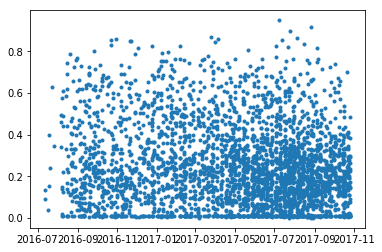

In [20]:
plt.plot(data['pit'], data['future_bad_probability'],'.')

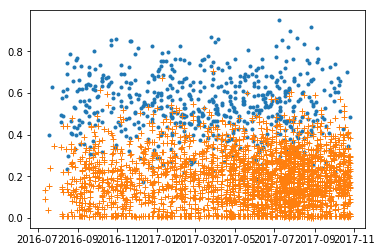

In [26]:
plt.plot(data[data['tag_in_six_months']=='bad']['pit'], data[data['tag_in_six_months']=='bad']['future_bad_probability'],'.')
plt.plot(data[data['tag_in_six_months']=='good']['pit'], data[data['tag_in_six_months']=='good']['future_bad_probability'],'+')


In [30]:
data['year'] = data['pit'].dt.year
data['month'] = data['pit'].dt.month
data['day'] = data['pit'].dt.day

### Univariate analysis: Distribution for each feature

- Some features, for example `sum_failed_repayments `, `recent_successful_repayments`, `credit_open_balance` are strongly right skewed.


- Only 2 clients with `missing_report` being 1.


- There are strange values in `credit_score` and `external score`: being negative and/or extremely large, which need to be taken care of later.


- `max_successful_repayments` represents number of successful repayments which should not be negative, but one observes some negative values in this feature. 

In [32]:
feature_list = list(data.columns.values) 
[feature_list.remove(feature) for feature in ['client_id','pit','future_bad_probability','tag_in_six_months']]
print('Number of original features', len(feature_list))
#feature_list

Number of original features 16


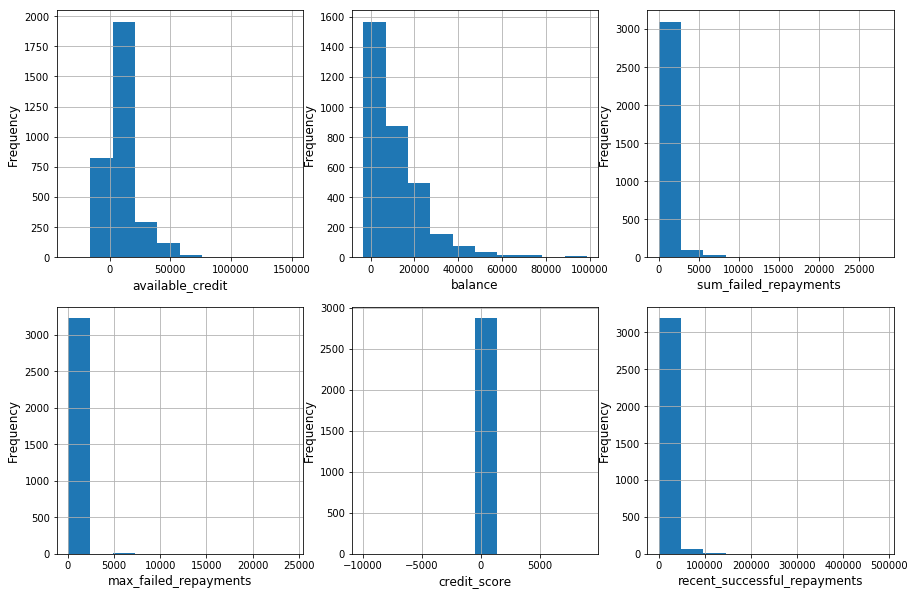

In [33]:
# histogram
plt.figure(figsize = (15,10))
count = 0
for feature in feature_list[0:6]:
    plt.subplot(str(23) + str(count))
    count += 1
    data[feature].hist()
    plt.ylabel('Frequency', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.xticks(rotation=0)


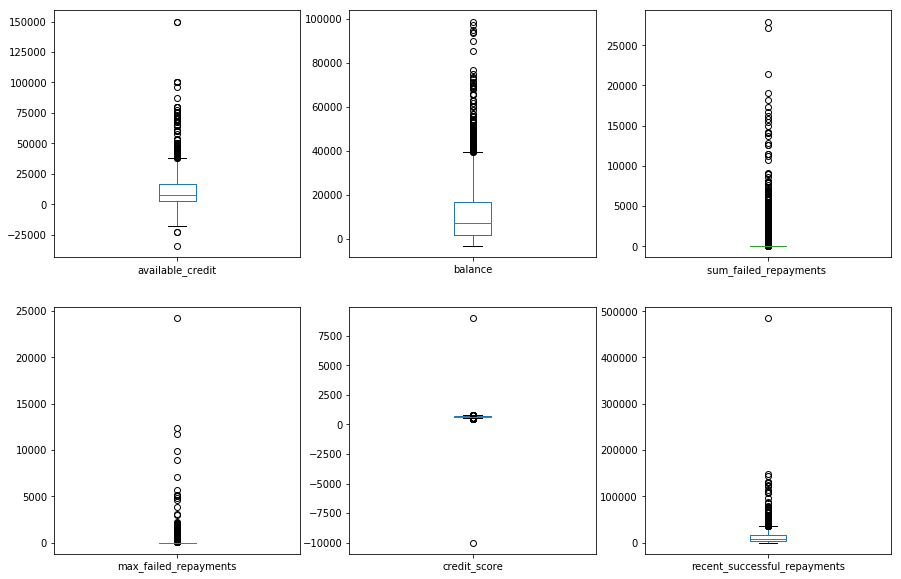

In [34]:
# box plots
plt.figure(figsize = (15,10))
count = 0
for feature in feature_list[:6]:
    plt.subplot(str(23) + str(count))
    count += 1
    data[feature].plot.box()
    plt.xticks(rotation=0)


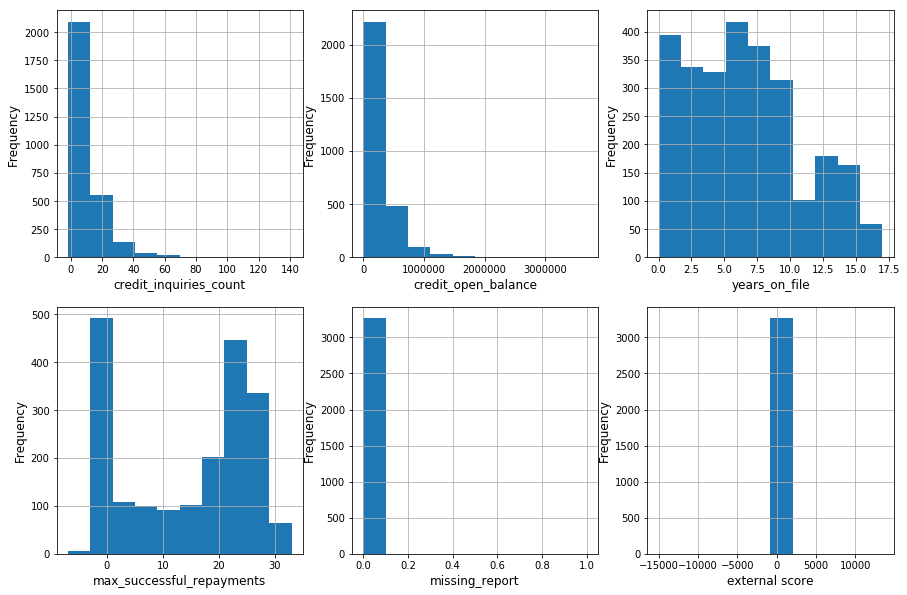

In [35]:
plt.figure(2, figsize = (15,10))
count = 0
for feature in feature_list[6:12]:
    plt.subplot(str(23) + str(count))
    count += 1
    data[feature].hist()
    plt.ylabel('Frequency', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.xticks(rotation=0)

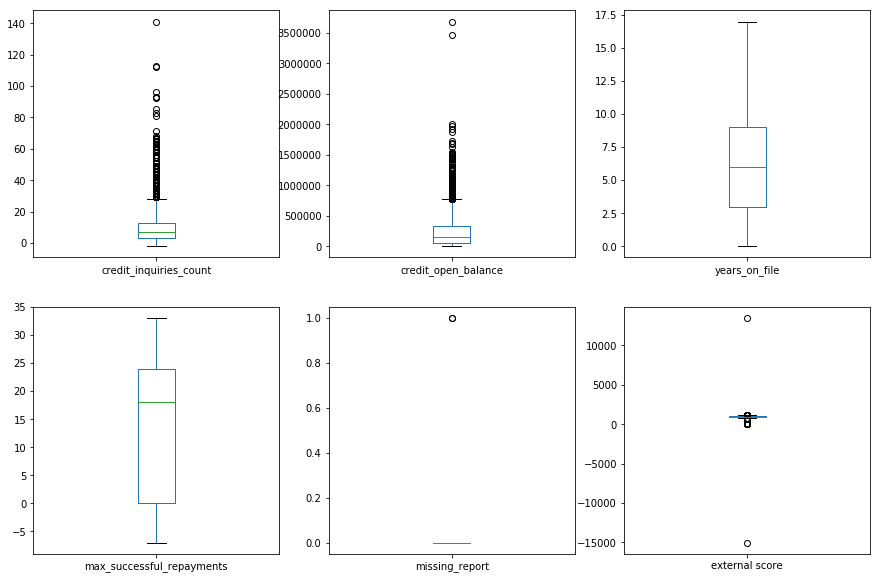

In [36]:
plt.figure(1, figsize = (15,10))
count = 0
for feature in feature_list[6:12]:
    plt.subplot(str(23) + str(count))
    count += 1
    data[feature].plot.box()
    plt.xticks(rotation=0)

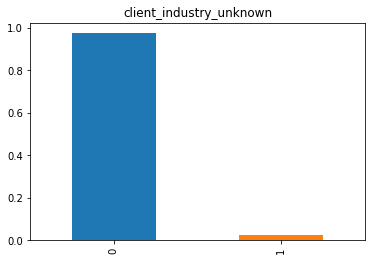

In [37]:
# the last in feature list
data['client_industry_unknown'].value_counts(normalize=True).plot.bar(title= 'client_industry_unknown')
plt.show()

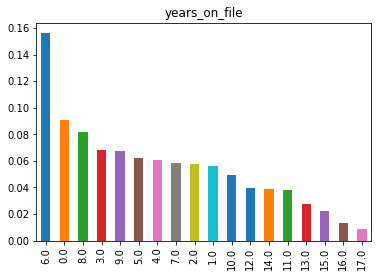

In [38]:
# another categorical feature: years_on_file
data['years_on_file'].value_counts(normalize=True).plot.bar(title= 'years_on_file')
plt.show()

In [39]:
data['missing_report'].value_counts()

0    3262
1       2
Name: missing_report, dtype: int64

#### Distributions

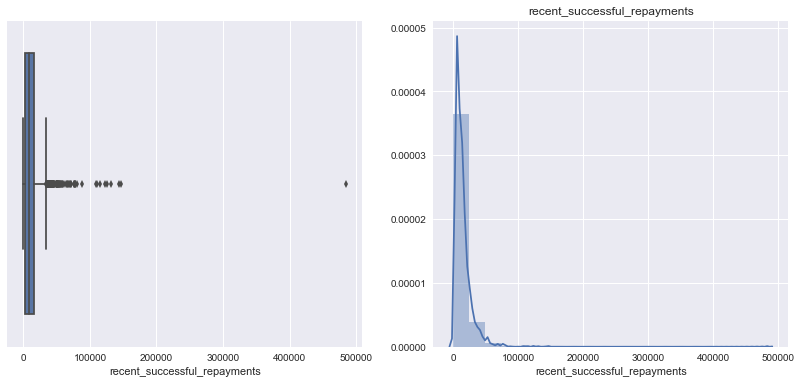

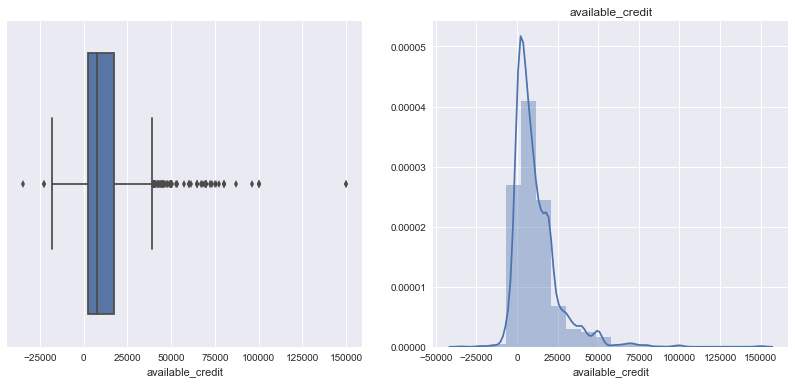

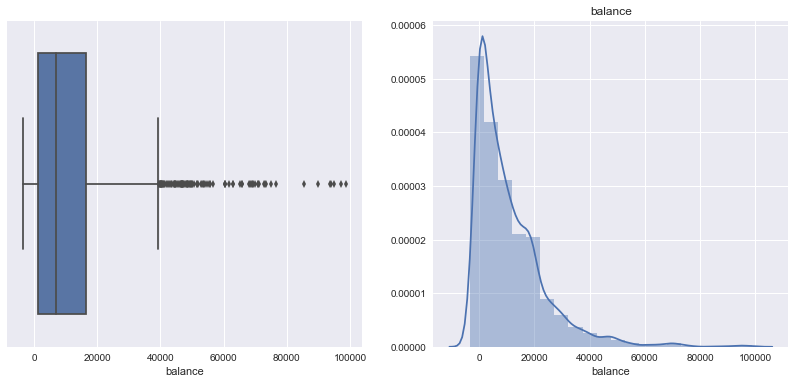

In [99]:
plots = ['recent_successful_repayments', 'available_credit', 'balance']
for i in plots:
    plt.figure(figsize = (14, 6))
    plt.subplot(1,2,1)
    sns.boxplot(data[i])
    plt.subplot(1,2,2)
    sns.distplot(data[i],bins= 20)    
    plt.title(i)    
    plt.show()

#### Pair plots

In [86]:
data.columns

Index(['client_id', 'pit', 'recent_successful_repayments',
       'future_bad_probability', 'available_credit', 'balance',
       'sum_failed_repayments ', 'max_failed_repayments', 'credit_score',
       'external score', 'credit_inquiries_count', 'credit_open_balance',
       'years_on_file', 'missing_report', 'client_industry_unknown',
       'tag_in_six_months', 'year', 'month', 'day'],
      dtype='object')

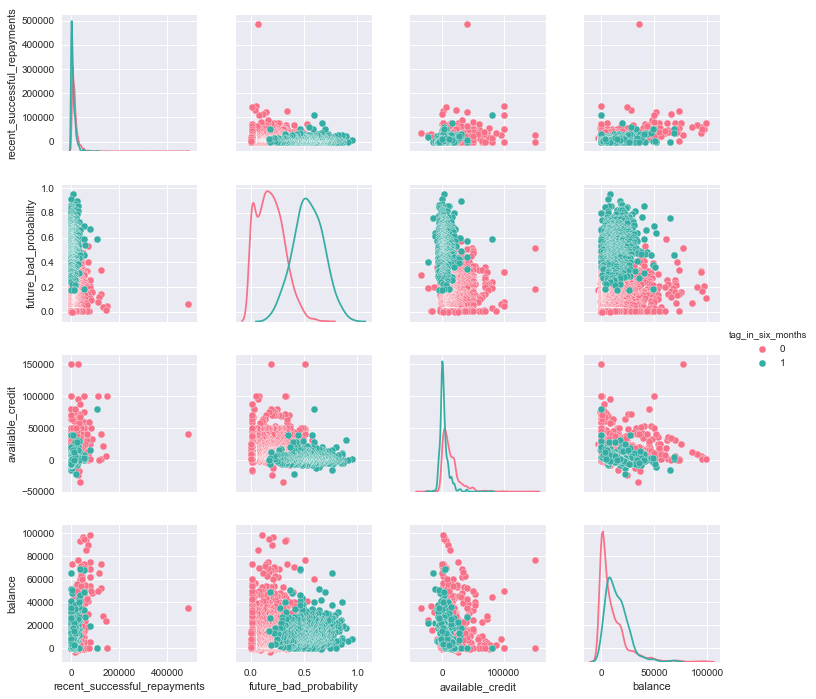

In [94]:
# Create a pair plot colored by target column values with a density plot of the diagonal
sns.pairplot(data, hue = 'tag_in_six_months', \
             diag_kind = 'kde',
             vars = ['recent_successful_repayments','future_bad_probability', 'available_credit', 'balance'], \
             palette = 'husl')

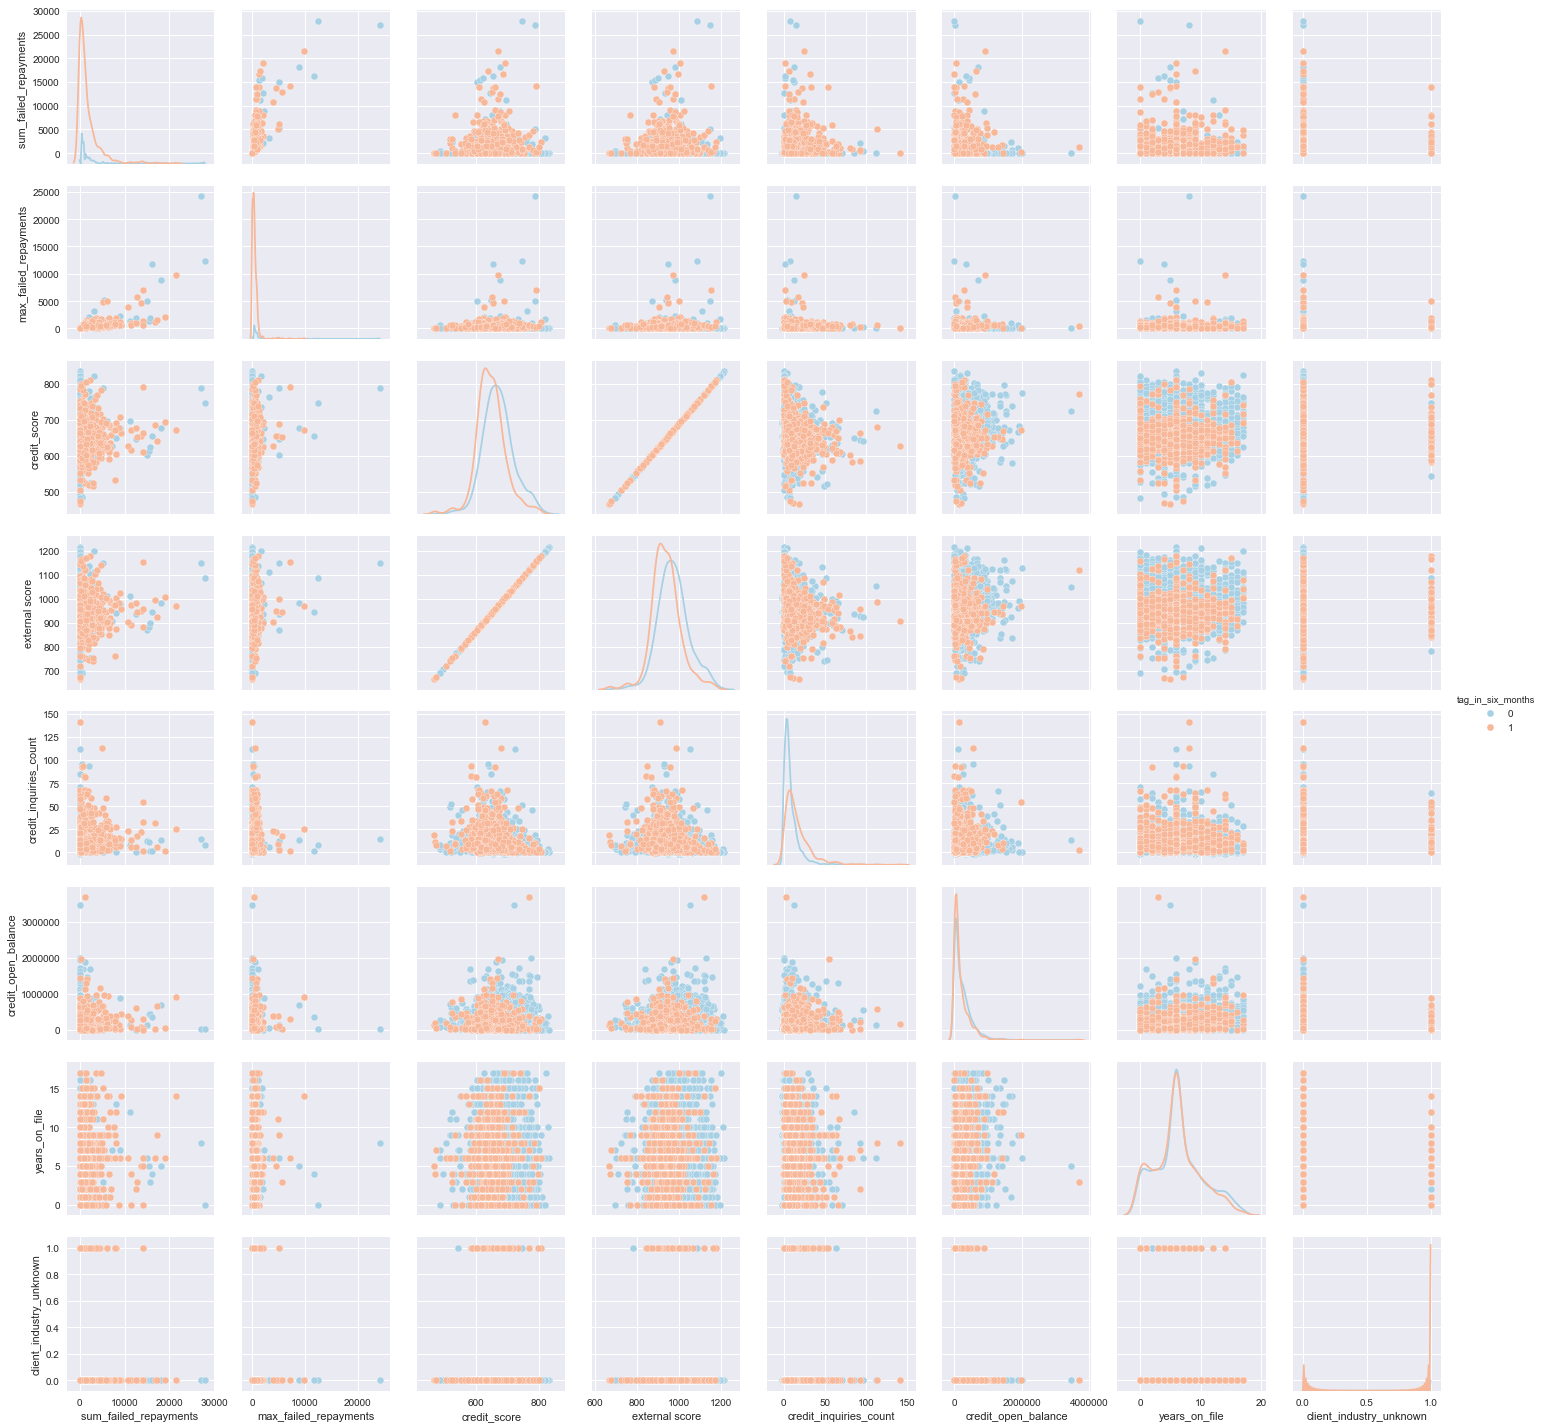

In [100]:
# Creating a pairplot with hue defined by target column
sns.pairplot(data, hue = 'tag_in_six_months', \
             diag_kind = 'kde',\
             vars = ['sum_failed_repayments ', 'max_failed_repayments', 'credit_score',
       'external score', 'credit_inquiries_count', 'credit_open_balance',
       'years_on_file', 'client_industry_unknown'],
            palette='RdBu_r')

### Missing values and outlier treatment

- With more than 40% values missing in **`max_successful_repayments`**, any imputation will strongly introduce bias to the result. Also some strange negative values appear in this column. Therefore, I drop this feature.


- Missing values for **`sum_failed_repayments `** and **`max_failed_repayments`** happen for the same clients. On the one hand, these two features are important signals to predict future payments being successful or not. Moreover, these clients also have several missing values in other fields like `credit_inquiries_count`, `credit_open_balance`, `years_on_file`. So I decide to not impute them and to drop all all 27 clients with missing reports for the two features. 


- 400 clients with unusual values for **`external score`**: 380 with a score -34, 1 with -15038.5, and 1 with 13469, while normal values should be from 0 to 1300. These clients also mostly don't have a credit score, except two of them with strange **`credit_score`** values, -10003 and 9002. Unless the minus and unusual scores are intentionally put in the dataset with a well-defined meaning, for now, I assume it's an error, and so neglect the rows with those values. 


- After all the above steps, all missing values in categorical features,  493 for **`years_on_file`** and 36 for **`credit_inquiries_count`**, are filled with the most frequent values. For numerical continuous features, the missing values are filled with mean values.    
    


In [40]:
# how many null values in each column
data.isnull().sum()

client_id                          0
pit                                0
recent_successful_repayments       2
future_bad_probability             0
available_credit                  40
balance                           30
sum_failed_repayments             27
max_failed_repayments             27
credit_score                     394
external score                     0
credit_inquiries_count           407
credit_open_balance              422
years_on_file                    593
max_successful_repayments       1316
missing_report                     0
client_industry_unknown            0
tag_in_six_months                  0
year                               0
month                              0
day                                0
dtype: int64

In [41]:
data[feature_list].describe()

,recent_successful_repayments,available_credit,balance,sum_failed_repayments,max_failed_repayments,credit_score,external score,credit_inquiries_count,credit_open_balance,years_on_file,max_successful_repayments,missing_report,client_industry_unknown,year,month,day
count,3262.000000,3224.000000,3234.000000,3237.000000,3237.000000,2870.000000,3264.000000,2857.000000,2.842000e+03,2671.000000,1948.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000
mean,12217.431914,11267.508935,11087.993945,462.737435,148.683132,666.801742,845.467371,10.191810,2.354995e+05,6.538001,14.377823,0.000613,0.025429,2016.803309,6.805147,16.166054
std,16072.690860,13474.252301,12725.722346,1678.738423,684.793241,257.745380,487.483521,11.611578,2.776411e+05,4.298588,10.811879,0.024750,0.157448,0.397558,2.931858,8.660024
min,-134.298380,-34469.619210,-3392.749645,0.000000,0.000000,-10003.000000,-15038.500000,-2.000000,0.000000e+00,0.000000,-7.000000,0.000000,0.000000,2016.000000,1.000000,1.000000
25%,3426.315983,2298.860872,1488.335920,0.000000,0.000000,635.000000,896.000000,3.000000,4.635325e+04,3.000000,0.000000,0.000000,0.000000,2017.000000,5.000000,9.000000
50%,8660.582997,7506.533762,7317.102283,0.000000,0.000000,664.000000,950.000000,7.000000,1.422555e+05,6.000000,18.000000,0.000000,0.000000,2017.000000,7.000000,16.000000
75%,16088.145615,16591.306435,16666.572777,0.000000,0.000000,697.000000,1002.500000,13.000000,3.362685e+05,9.000000,24.000000,0.000000,0.000000,2017.000000,9.000000,24.000000
max,485126.766200,150020.533000,98773.000520,27948.846780,24221.161920,9002.000000,13469.000000,141.000000,3.683657e+06,17.000000,33.000000,1.000000,1.000000,2017.000000,12.000000,31.000000


In [42]:
data[data['max_successful_repayments']==0].shape

(462, 20)

In [43]:
# Drop max_successful_repayments feature
data.drop(columns ='max_successful_repayments', inplace = True)
feature_list.remove('max_successful_repayments')

In [44]:
# Check missing values in 'sum_failed_repayments ' feature
data[data['sum_failed_repayments '].isnull()].head()

,client_id,pit,recent_successful_repayments,future_bad_probability,available_credit,balance,sum_failed_repayments,max_failed_repayments,credit_score,external score,credit_inquiries_count,credit_open_balance,years_on_file,missing_report,client_industry_unknown,tag_in_six_months,year,month,day
48,35087,2016-08-15,43351.150830,0.741680,NaN,50548.237160,NaN,NaN,652.0,944.0,NaN,NaN,8.0,0,0,bad,2016,8,15
257,41682,2016-08-08,15058.527580,0.574760,4856.866558,10339.132570,NaN,NaN,709.0,1029.5,1.0,115729.0,NaN,0,0,bad,2016,8,8
413,35301,2016-08-06,NaN,0.493731,-6377.789302,26479.355760,NaN,NaN,663.0,960.5,NaN,NaN,6.0,0,0,bad,2016,8,6
507,42456,2016-08-06,NaN,0.458727,-1830.799690,13830.371240,NaN,NaN,623.0,900.5,8.0,40729.0,4.0,0,0,bad,2016,8,6
551,39526,2016-08-10,4329.021963,0.441901,6689.979235,5346.076094,NaN,NaN,658.0,953.0,6.0,45672.0,9.0,0,0,good,2016,8,10


In [45]:
# Drop rows with missing values in 'sum_failed_repayments '
data.dropna(subset=['sum_failed_repayments '], inplace = True)


In [46]:
# how many null values in each column
data.isnull().sum()

client_id                         0
pit                               0
recent_successful_repayments      0
future_bad_probability            0
available_credit                 32
balance                          27
sum_failed_repayments             0
max_failed_repayments             0
credit_score                    380
external score                    0
credit_inquiries_count          389
credit_open_balance             403
years_on_file                   577
missing_report                    0
client_industry_unknown           0
tag_in_six_months                 0
year                              0
month                             0
day                               0
dtype: int64

In [47]:
# Check clients with negative or unrealistically high (>900) credit score
data[(data['credit_score']<0) | (data['credit_score']>900)]

,client_id,pit,recent_successful_repayments,future_bad_probability,available_credit,balance,sum_failed_repayments,max_failed_repayments,credit_score,external score,credit_inquiries_count,credit_open_balance,years_on_file,missing_report,client_industry_unknown,tag_in_six_months,year,month,day
811,24352,2016-08-21,12139.44325,0.356432,3234.281929,6698.929303,0.0,0.0,9002.0,13469.0,0.0,0.0,NaN,0,0,good,2016,8,21
3306,38889,2017-08-08,13562.85458,0.007143,11057.729510,14039.060570,0.0,0.0,-10003.0,-15038.5,NaN,NaN,3.0,0,0,good,2017,8,8


In [48]:
# Check 400 clients with negative or unrealistically high (>1300) external score: external score values
data[(data['external score']<0) | (data['external score']>1300)]['external score'].value_counts()

-34.0       380
-15038.5      1
 13469.0      1
Name: external score, dtype: int64

In [49]:
# Check 400 clients with negative or unrealistically high (>1300) external score: credit_score values
data[(data['external score']<0) | (data['external score']>1300)]['credit_score'].value_counts()

-10003.0    1
 9002.0     1
Name: credit_score, dtype: int64

In [50]:
# Check 400 clients with negative or unrealistically high (>1300) external score: credit_inquiries_count values
data[(data['external score']<0) | (data['external score']>1300)]['credit_inquiries_count'].value_counts()

 2.0     5
 0.0     4
 4.0     3
 7.0     3
 3.0     3
 6.0     3
 8.0     1
 13.0    1
 14.0    1
 12.0    1
-1.0     1
 36.0    1
 32.0    1
 9.0     1
Name: credit_inquiries_count, dtype: int64

In [51]:
# Drop 400 clients with negative or unrealistically high (>1300) external score
row_to_drop = data[(data['external score']<0) | (data['external score']>1300)].index
data.drop(row_to_drop, inplace = True)

In [52]:
# Check number of missing values 
data.isnull().sum()

client_id                         0
pit                               0
recent_successful_repayments      0
future_bad_probability            0
available_credit                 14
balance                          15
sum_failed_repayments             0
max_failed_repayments             0
credit_score                      0
external score                    0
credit_inquiries_count           36
credit_open_balance              29
years_on_file                   493
missing_report                    0
client_industry_unknown           0
tag_in_six_months                 0
year                              0
month                             0
day                               0
dtype: int64

In [53]:
# Fill missing values in the remain categorical features with the most frequent value
for feature in ['years_on_file', 'credit_inquiries_count']:
    data.fillna(value={feature: data[feature].mode()[0]}, inplace = True)

In [54]:
# Fill missing values in the remain continuous features with mean values
for feature in ['available_credit', 'balance', 'credit_open_balance']:
    data.fillna(value={feature: data[feature].mean()}, inplace = True)

In [55]:
data.shape

(2855, 19)

In [56]:
# Check number of missing values 
data.isnull().sum()

client_id                       0
pit                             0
recent_successful_repayments    0
future_bad_probability          0
available_credit                0
balance                         0
sum_failed_repayments           0
max_failed_repayments           0
credit_score                    0
external score                  0
credit_inquiries_count          0
credit_open_balance             0
years_on_file                   0
missing_report                  0
client_industry_unknown         0
tag_in_six_months               0
year                            0
month                           0
day                             0
dtype: int64

### Class frequency

The dataset is imbalanced since only ~20% of the data is positive - having **`tag_in_six_months`** being 'bad'.

A visualization to see how well the CompanyX provided prediction **`future_bad_probability`** separates the two classes.

In [57]:
# Replace class labels 'bad', 'good' with 1 and 0
data['tag_in_six_months'].replace({'bad':1,'good':0},inplace=True)

number of class bad/1 samples  565
number of class good/0 samples  2290


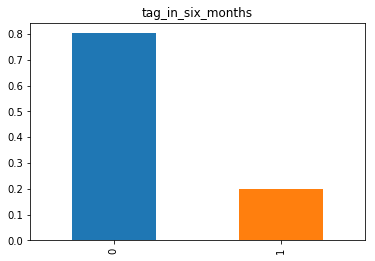

In [58]:
# Number of samples in each class
data['tag_in_six_months'].value_counts(normalize=True).plot.bar(title= 'tag_in_six_months')
print('number of class bad/1 samples ', data[data['tag_in_six_months'] == 1].shape[0])
print('number of class good/0 samples ', data[data['tag_in_six_months'] == 0].shape[0])

plt.show()

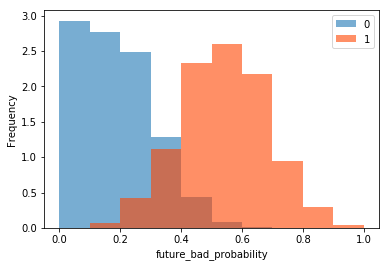

In [59]:
# Provided CompanyX model prediction versus the class label
plt.hist(data[data['tag_in_six_months']==0]['future_bad_probability'], \
         bins=np.arange(0,1.1,0.1), alpha=0.6, label='0', density = True)
plt.hist(data[data['tag_in_six_months']==1]['future_bad_probability'], \
         bins=np.arange(0,1.1,0.1), alpha=0.6, label='1', color = 'orangered', density = True)
plt.xlabel('future_bad_probability')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

### Bivariate analysis/Correlations: features-class

- **`credit_score`** and **`external_score`** are linear dependent with correlation score being 1. We'll leave `external_score` out of the feature list for training later.


- **`sum_failed_repayments `** and **`max_failed_repayments`** are highly correlated. Since `sum_failed_repayments ` is more correlated to the class label 'tag_in_six_months', I'll keep this feature while neglecting to use  `max_failed_repayments` for the classification later.


- `recent_successful_repayments` and `balance` are correlated, but keep them both for now. 


- **`missing_report`** column has only one value 0, i.e no predictive power, so I'll drop this column. 


- The class label **`tag_in_six_months`** correlates the most with `sum_failed_repayments`, `available_credit`, `credit_inquiries_count`, `client_industry_unknown`.

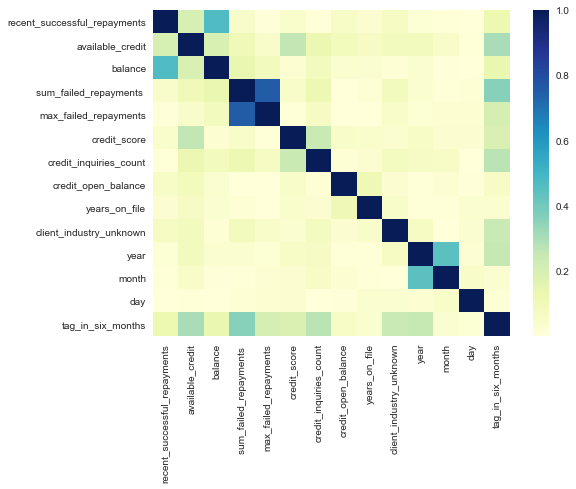

In [84]:
plt.figure(figsize = (8,6))
sns.heatmap(data[feature_list + ['tag_in_six_months']].corr().abs(),cmap="YlGnBu",annot=False) #, cmap="Set2"
plt.show()

In [61]:
# 'missing_report' has only one value
data.missing_report.value_counts()

0    2855
Name: missing_report, dtype: int64

In [62]:
# Correlation coefficients 
data[feature_list + ['tag_in_six_months']].corr()

,recent_successful_repayments,available_credit,balance,sum_failed_repayments,max_failed_repayments,credit_score,external score,credit_inquiries_count,credit_open_balance,years_on_file,missing_report,client_industry_unknown,year,month,day,tag_in_six_months
recent_successful_repayments,1.000000,0.200754,0.470852,-0.050497,-0.004413,0.041153,0.041153,-0.010887,0.057506,0.027802,NaN,-0.072960,0.021923,-0.011118,0.001492,-0.126156
available_credit,0.200754,1.000000,-0.191735,-0.108138,-0.048590,0.259626,0.259626,-0.131996,0.090221,0.062840,NaN,-0.087591,0.086110,0.053598,0.010638,-0.304381
balance,0.470852,-0.191735,1.000000,0.134496,0.088939,-0.023734,-0.023734,0.089214,0.036887,0.031938,NaN,0.018581,0.038582,-0.006367,-0.002957,0.139543
sum_failed_repayments,-0.050497,-0.108138,0.134496,1.000000,0.754314,-0.053152,-0.053152,0.124152,-0.003615,-0.016402,NaN,0.089163,-0.036626,0.008013,-0.018350,0.359577
max_failed_repayments,-0.004413,-0.048590,0.088939,0.754314,1.000000,0.008776,0.008776,0.073104,-0.000584,0.000081,NaN,0.052780,-0.023391,0.025758,-0.026341,0.204648
credit_score,0.041153,0.259626,-0.023734,-0.053152,0.008776,1.000000,1.000000,-0.241675,0.054105,0.041759,NaN,-0.036495,0.058709,0.029865,0.030827,-0.190221
external score,0.041153,0.259626,-0.023734,-0.053152,0.008776,1.000000,1.000000,-0.241675,0.054105,0.041759,NaN,-0.036495,0.058709,0.029865,0.030827,-0.190221
credit_inquiries_count,-0.010887,-0.131996,0.089214,0.124152,0.073104,-0.241675,-0.241675,1.000000,0.017915,-0.029656,NaN,0.078526,-0.065778,-0.059313,-0.002047,0.271400
credit_open_balance,0.057506,0.090221,0.036887,-0.003615,-0.000584,0.054105,0.054105,0.017915,1.000000,0.114438,NaN,-0.027653,0.010530,0.023719,0.004179,-0.059264
years_on_file,0.027802,0.062840,0.031938,-0.016402,0.000081,0.041759,0.041759,-0.029656,0.114438,1.000000,NaN,-0.052387,-0.008955,0.010052,0.036486,-0.036325


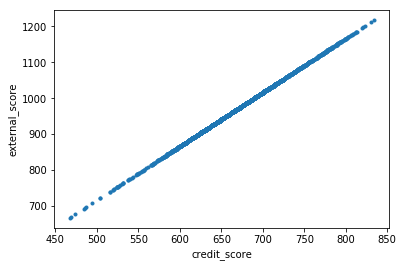

In [63]:
# Check the linear dependence between credit_score and external score
plt.plot(data['credit_score'], data['external score'],'.')
plt.xlabel('credit_score')
plt.ylabel('external_score')
plt.show()

In [64]:
# Drop 'external score', 'max_failed_repayments' due to high correlation, and 'missing_report'
feature_list.remove('external score')
feature_list.remove('missing_report')
feature_list

['recent_successful_repayments',
 'available_credit',
 'balance',
 'sum_failed_repayments ',
 'max_failed_repayments',
 'credit_score',
 'credit_inquiries_count',
 'credit_open_balance',
 'years_on_file',
 'client_industry_unknown',
 'year',
 'month',
 'day']

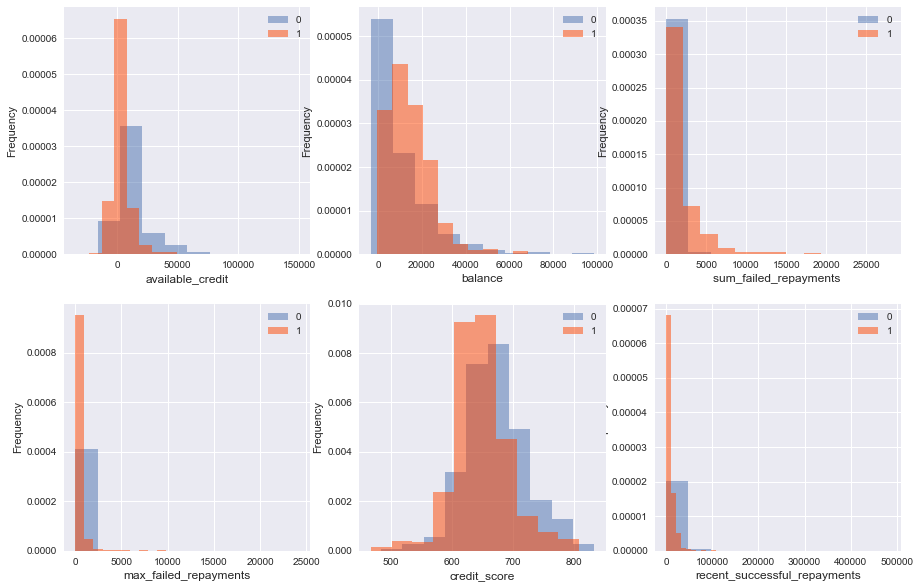

In [65]:
# How well each feature can separate between two classes based on value distribution   
sns.set()
plt.figure(figsize = (15,10))
count = 0
for feature in feature_list[0:6]: 
    plt.subplot(str(23) + str(count))
    count += 1
    plt.hist(data[data['tag_in_six_months']==0][feature], alpha=0.5, label='0', density = True)
    plt.hist(data[data['tag_in_six_months']==1][feature], alpha=0.5, label='1', density = True, color = 'orangered')
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')


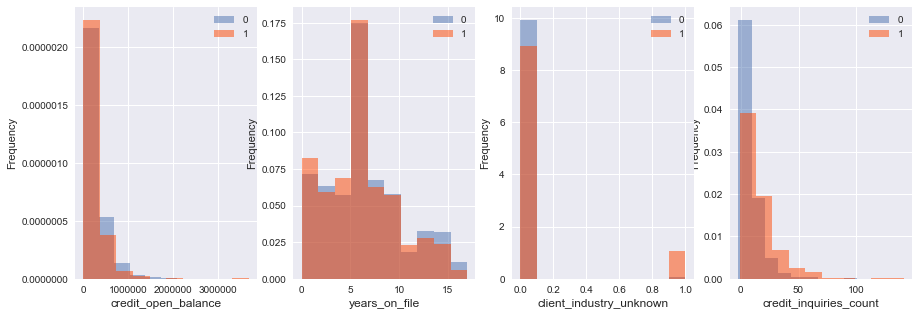

In [77]:
# How well each feature can separate between two classes based on value distribution - continue
sns.set()
plt.figure(figsize = (15,5))
count = 0
for feature in feature_list[6:10]: 
    plt.subplot(str(14) + str(count))
    count += 1
    plt.hist(data[data['tag_in_six_months']==0][feature], alpha=0.5, label='0', density = True)
    plt.hist(data[data['tag_in_six_months']==1][feature], alpha=0.5, label='1', density = True, color = 'orangered')
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')


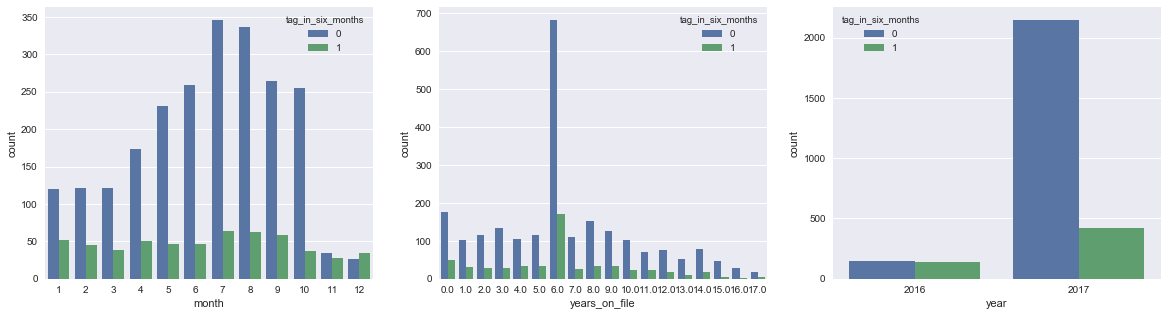

In [82]:
plt.figure(figsize = (20,5))
count = 0
for feature in ['year', 'month', 'years_on_file']:
    plt.subplot(str(13) + str(count))
    count += 1
    sns.countplot(feature,hue='tag_in_six_months',data= data) 

## Modeling

This is a binary classification problem on an imbalance dataset. Since there are both categorical and continuous variables with different distributions and also correlation among variables, I choose random forest (RF) - a tree based model - to start with.

For a quick implementation as a proof-of-concept, I won't do any model hyperparameter tuning, model selection, or cross validation. I'll use a simple default RF to train on 80% of the dataset and then evaluate and compare on the remain 20% data the trained model to the result from the current CompanyX model provided.

The metrics for evaluation include precision-recall curve and the score for the area under this curve as the dataset is unbalanced and my priority is to focus on predicting the positive class. The ROC and area-under-the-ROC curve AUC are also provided for comparison.   

### Data splitting 

The dataset is split into 80/20 for training and testing. 



In [68]:
# Split to 80% training and 20% test 
test_size = 0.2
offset_test = int((1-test_size)* data.shape[0])
idx = np.random.permutation(data.index.values)
idx_train, idx_test = idx[:offset_test], idx[offset_test:] 

X_train, y_train = data.loc[idx_train, feature_list], data.loc[idx_train,'tag_in_six_months']
X_test, y_test = data.loc[idx_test, feature_list], data.loc[idx_test,'tag_in_six_months']

# Probability predicted by the current model at CompanyX
y_train_proba_BVmodel = data.loc[idx_train,'future_bad_probability']
y_test_proba_BVmodel = data.loc[idx_test,'future_bad_probability']

### Random Forest model training

A default simple model with a maximum depth of the tree being 5. 

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve

RF = RandomForestClassifier(max_depth=5, random_state=1)
RF.fit(X_train, y_train)
y_test_RF = RF.predict(X_test)
y_test_proba_RF = RF.predict_proba(X_test)[:,1] # keep probabilities for the positive outcome only

print('Accuracy on test set with random forrest ' ,'%.2f'  %(100*accuracy_score(y_test, y_test_RF)), '%' )
print('Accuracy on training set with random forrest ' ,'%.2f'  %(100*accuracy_score(y_train, RF.predict(X_train))), '%' )


Accuracy on test set with random forrest  91.07 %
Accuracy on training set with random forrest  92.78 %


### Model evaluation: precision-recall, ROC

A simple 5-max-depth random forest model is able to get an AUC score with precision-recall curve of 0.82 compared to 0.89 by the CompanyX model.

For ROC curve, the random forest model gives an AUC of 0.92 compared to 0.97 by the CompanyX model.

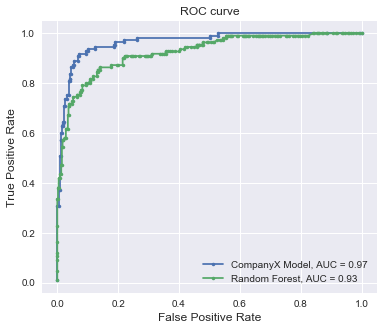

In [70]:
# ROC curve
from sklearn.metrics import roc_curve, auc

# calculate ROC curve for the trained random forest model and the CompanyX model 
fpr_RF, tpr_RF, _ = roc_curve(y_test, y_test_proba_RF)
fpr_BVmodel, tpr_BVmodel, _ = roc_curve(y_test, y_test_proba_BVmodel)

# calculate the area under the curve score
auc_roc_RF = auc(fpr_RF, tpr_RF)
auc_roc_BVmodel = auc(fpr_BVmodel, tpr_BVmodel)

plt.figure(figsize=(6,5))
plt.plot(fpr_BVmodel, tpr_BVmodel, '.-', label="CompanyX Model, AUC = %.2f" % (auc_roc_BVmodel))
plt.plot(fpr_RF, tpr_RF, '.-', label="Random Forest, AUC = %.2f" % (auc_roc_RF))
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curve', fontsize=12)
plt.legend(loc=4)
plt.show()

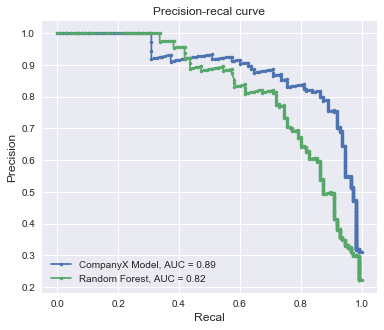

In [71]:
# Precision-recall curve
from sklearn.metrics import precision_recall_curve, auc

# calculate precision-recall curve
precision_RF, recall_RF, _ = precision_recall_curve(y_test,  y_test_proba_RF)
precision_BVmodel, recall_BVmodel, _ = precision_recall_curve(y_test, y_test_proba_BVmodel)

# calculate the under the curve score - AUC
auc_RF = auc(recall_RF, precision_RF)
auc_BVmodel = auc(recall_BVmodel, precision_BVmodel)

# plot
plt.figure(figsize=(6,5))
plt.plot(recall_BVmodel, precision_BVmodel, marker='.',\
         label="CompanyX Model, AUC = %.2f" % (auc_BVmodel) )
plt.plot(recall_RF, precision_RF, marker='.',\
         label="Random Forest, AUC = %.2f" % (auc_RF))
plt.xlabel('Recal', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-recal curve', fontsize=12)
plt.legend()
plt.show()


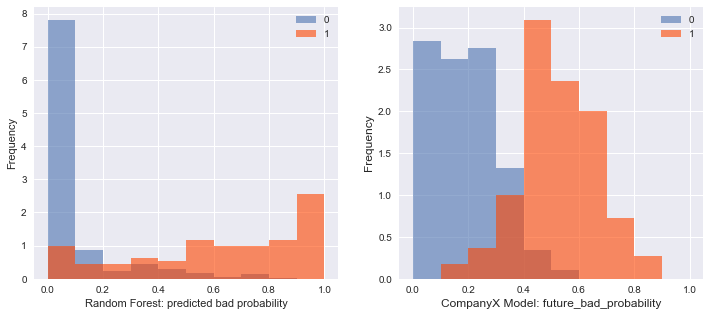

In [72]:
# Visualize how well each model separates the two classes 
plt.figure(figsize=(12,5))

# Random Forest model
plt.subplot(121)
plt.hist(y_test_proba_RF[y_test==0], \
         bins=np.arange(0,1.1,0.1), alpha=0.6, label='0', density = True)
plt.hist(y_test_proba_RF[y_test==1], \
         bins=np.arange(0,1.1,0.1), alpha=0.6, label='1', color = 'orangered', density = True)
plt.xlabel('Random Forest: predicted bad probability')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# CompanyX provided result
plt.subplot(122)
plt.hist(y_test_proba_BVmodel[y_test==0], \
         bins=np.arange(0,1.1,0.1), alpha=0.6, label='0', density = True)
plt.hist(y_test_proba_BVmodel[y_test==1], \
         bins=np.arange(0,1.1,0.1), alpha=0.6, label='1', color = 'orangered', density = True)
plt.xlabel('CompanyX Model: future_bad_probability', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(loc='upper right')

plt.show()

### Feature importance

As expected in the correlation session above, the most important indicators for a bad client are related to amount of failed repayments and available credit, credit inquiry count.

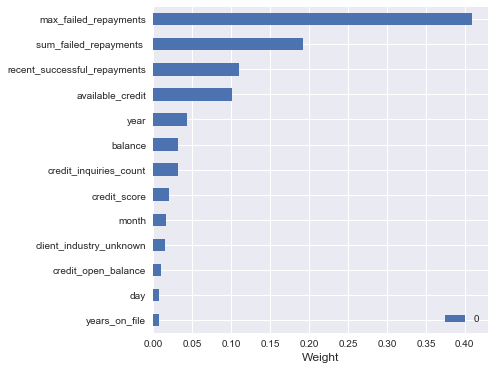

In [73]:
# create dictionary
vdict = {}
for ii in range(len(X_train.columns)):
    vdict[X_train.columns[ii]] = RF.feature_importances_[ii]
df_imp = pd.DataFrame.from_dict(vdict, orient='index')

# plot weights
df_imp.sort_values(by=0).plot.barh(figsize=(6,6))
plt.xlabel('Weight', fontsize=12)
plt.show()